
# Metal vs. Non-Metal Classification on matbench_expt_is_metal
## Using Intermetallic Features + XGBoost + Threshold Tuning

---

This script demonstrates how to:
1) Load the matbench_expt_is_metal dataset.
2) Parse each composition to extract newly added "intermetallic" features
   (via the SMACT-based module code provided).
3) Build a pipeline to train an XGBoost classifier on these features.
4) Tune XGBoost hyperparameters and the 'intermetallic_threshold' parameter
   to see how it affects classification performance.
5) Evaluate via cross-validation, confusion matrices, classification metrics.
6) Perform SHAP feature analysis to understand feature importance.

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# Machine learning / model-related imports
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from xgboost import XGBClassifier

# SHAP + matplotlib + seaborn for plotting and feature importance analysis
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# composition parsing and new features
from pymatgen.core import Composition


## 1. Loading the full matbench_expt_is_metal dataset

In [ ]:
try:
    from matminer.datasets import load_dataset
    
    # Load the full dataset from matminer
    df = load_dataset("matbench_expt_is_metal")
    # The dataframe should have columns: ["composition", "is_metal"]
    # Confirm we have 4921 entries
    print(f"Loaded dataset with {len(df)} entries.")
    
except ImportError:
    raise ImportError("Please install matminer or load the CSV file version of the dataset.")

Loaded dataset with 4921 entries.


## 2. Feature extraction - Intermetallic descriptors

In [ ]:

def extract_intermetallic_features(comp_str: str) -> dict:
    """
    Given a composition string, parse it and return
    a dictionary of the new intermetallic features.
    """
    # Convert string to Composition
    comp = Composition(comp_str)

    # Compute features using the newly introduced SMACT functions
    from smact.intermetallics import (
        get_metal_fraction,
        get_d_electron_fraction,
        get_distinct_metal_count,
        get_pauling_test_mismatch,
        intermetallic_score
    )

    feats = {}
    feats["metal_fraction"] = get_metal_fraction(comp)
    feats["d_electron_fraction"] = get_d_electron_fraction(comp)
    feats["distinct_metal_count"] = get_distinct_metal_count(comp)
    feats["pauling_mismatch"] = get_pauling_test_mismatch(comp)
    feats["intermetallic_score"] = intermetallic_score(comp)

    return feats


print("Extracting intermetallic features for each sample ...")
all_features = []
for i, row in df.iterrows():
    feats = extract_intermetallic_features(row["composition"])
    all_features.append(feats)

X_featurized = pd.DataFrame(all_features)
y = df["is_metal"].values

print("Feature extraction complete!")
print(X_featurized.head())


Extracting intermetallic features for each sample ...
Feature extraction complete!
   metal_fraction  d_electron_fraction  distinct_metal_count  \
0        0.600000             0.600000                     2   
1        0.333333             0.333333                     2   
2        0.448276             0.068966                     3   
3        0.448276             0.068966                     3   
4        0.500000             0.500000                     1   

   pauling_mismatch  intermetallic_score  
0          0.546667             0.632583  
1         -0.020000             0.582464  
2          0.236667             0.567517  
3          0.251667             0.565267  
4          0.430000             0.552167  


## 3. Model + Cross-validation + Threshold tuning

In [ ]:

def custom_threshold_predictions(proba, threshold):
    """
    Convert continuous probabilities to binary predictions using a custom threshold.
    By default, the classifier uses 0.5. We allow a different cutoff to see how
    sensitive the classification is to the intermetallic threshold logic.
    """
    return (proba >= threshold).astype(int)


# We will set up a grid of XGBoost hyperparameters + thresholds to tune:
param_grid = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 6],
    "n_estimators": [100, 200],
    # We'll handle the intermetallic_threshold external to XGB's own param_grid
    # so we won't put threshold here. We'll do a loop over thresholds.
}


## 4. Hyperparameter/Threshold search with cross-validation

In [ ]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_score = -np.inf
best_params = {}
thresholds = [0.5, 0.6, 0.7, 0.8] # intermetallic_threshold

for lr in param_grid["learning_rate"]:
    for md in param_grid["max_depth"]:
        for ne in param_grid["n_estimators"]:
            for thres in thresholds:

                # Initialize the classifier
                clf = XGBClassifier(
                    learning_rate=lr,
                    max_depth=md,
                    n_estimators=ne,
                    use_label_encoder=False,
                    eval_metric="logloss",
                    random_state=42
                )

                # We'll do manual cross-val:
                fold_accuracies = []
                for train_idx, val_idx in cv.split(X_featurized, y):
                    X_train_cv = X_featurized.iloc[train_idx]
                    y_train_cv = y[train_idx]
                    X_val_cv = X_featurized.iloc[val_idx]
                    y_val_cv = y[val_idx]

                    # Train
                    clf.fit(X_train_cv, y_train_cv)
                    
                    # Predict with custom threshold
                    y_proba_val = clf.predict_proba(X_val_cv)[:, 1]
                    y_pred_val = custom_threshold_predictions(y_proba_val, thres)

                    fold_accuracies.append(accuracy_score(y_val_cv, y_pred_val))

                mean_acc = np.mean(fold_accuracies)

                # Track best
                if mean_acc > best_score:
                    best_score = mean_acc
                    best_params = {
                        "learning_rate": lr,
                        "max_depth": md,
                        "n_estimators": ne,
                        "threshold": thres,
                        "cv_accuracy": best_score
                    }

print("Best parameters found:")
print(best_params)

#this is still pending a cv of the intermetallic scores model weighting


Best parameters found:
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'threshold': 0.5, 'cv_accuracy': np.float64(0.8549071437414881)}


## 5. Retrain best model on full training set & evaluate


Test Accuracy: 0.852 with threshold=0.5

Classification Report:
              precision    recall  f1-score   support

       False       0.84      0.87      0.85       494
        True       0.86      0.83      0.85       491

    accuracy                           0.85       985
   macro avg       0.85      0.85      0.85       985
weighted avg       0.85      0.85      0.85       985



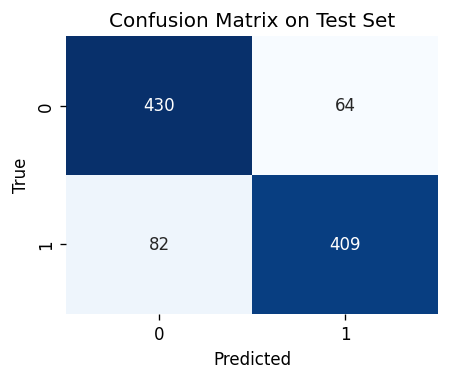

In [ ]:

# Usually you'd do a train/test split. Let's do that for a final check:
X_train, X_test, y_train, y_test = train_test_split(
    X_featurized, y, test_size=0.2, random_state=42, stratify=y
)

best_model = XGBClassifier(
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    n_estimators=best_params["n_estimators"],
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

best_model.fit(X_train, y_train)

# Evaluate on test set
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test = custom_threshold_predictions(y_proba_test, best_params["threshold"])

test_acc = accuracy_score(y_test, y_pred_test)
print(f"\nTest Accuracy: {test_acc:.3f} with threshold={best_params['threshold']}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(4, 3), dpi=120)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix on Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


## 6. SHAP feature analysis


Performing SHAP analysis...


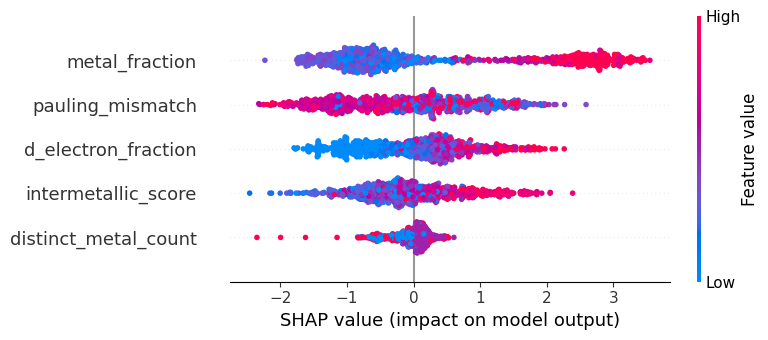

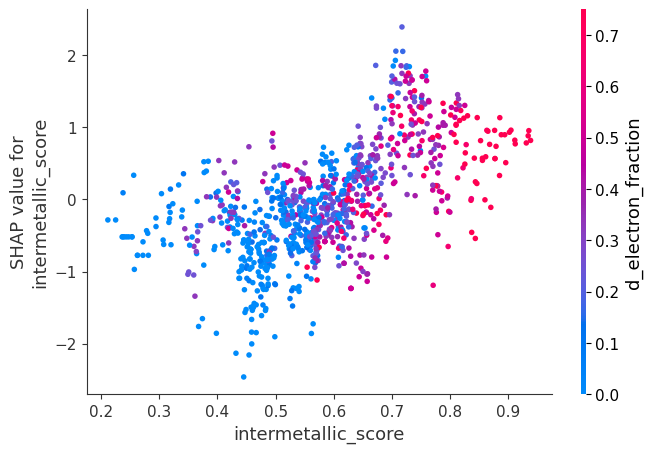


All done!


In [ ]:

print("\nPerforming SHAP analysis...")

# Create an explainer with the best model
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

# Dependence plot example (for any feature, say 'intermetallic_score')
if "intermetallic_score" in X_test.columns:
    shap.dependence_plot(
        "intermetallic_score", shap_values, X_test, display_features=X_test
    )

print("\nAll done!")
